# Projet python 

## Bruno Pincet, Quentin Navarre

### Table of Contents

* [1. Preprocessing](#chapter1)
* [2. Data Analysis](#chapter2)
* [3. Machine Learning](#chapter3)
    * [a/ Dataset](#section_3_1)
        * [Variance Treshold](#section_3_1_1)
        * [Get Dummies & Scaled Data](#section_3_1_2)
        * [Removing Correlated Features](#section_3_1_3)
    * [b. Supervised learning Model](#section_3_2)
        * [Linear SVC](#section_3_2_1)
            * [1.Normal](#section_3_2_1_1)
            * [2.Optimization - Recursive Feature Elimination and Grid Search](#section_3_2_1_2)
        * [KNeighborsClassifier](#section_3_2_2)
            * [1.Normal](#section_3_2_2_1)
            * [2.Optimization - Grid Search](#section_3_2_2_2)
        * [SVC](#section_3_2_3)
            * [1.Normal](#section_3_2_3_1)
            * [2.Optimization - Recursive Feature Elimination and Grid Search](#section_3_2_3_2)
        * [Random Forest](#section_3_2_4)
            * [1.Normal](#section_3_2_4_1)
            * [2.Optimization - Feature Elimination and Grid Search](#section_3_2_4_2)
    * [c. Deep Learning](#section_3_3)

    

### Libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as geo
import seaborn as sns
import folium
import random
import tensorflow as tf

from mapping_data import *
from pywaffle import Waffle
from IPython.display import Image,IFrame
from sklearn.feature_selection import VarianceThreshold,SelectFromModel,RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit,StratifiedKFold,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import regularizers

### Dataset source: 

In [2]:
IFrame('https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29', width=800, height=450)

## 1.Preprocessing <a class="anchor" id="chapter1"></a>

In [3]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data")


In [4]:
df.head()

,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0.4,CL0.5,CL0.6,CL0.7,CL0.8,CL0.9,CL0.10,CL2.2,CL0.11,CL0.12
0,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


CL0 Never Used 
CL1 Used over a Decade Ago 
CL2 Used in Last Decade 
CL3 Used in Last Year
CL4 Used in Last Month 
CL5 Used in Last Week 
CL6 Used in Last Day 

In [5]:
df.loc[len(df)]=df.columns
df.columns=(["id","age","gender","education","country","ethnicity","nscore","escore","oscore","ascore","cscore","impulsive","ss",
 "alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
 "lsd","meth","mushrooms","nicotine","semer","vsa"])
df["id"]=df["id"].astype(int)
df = df.set_index("id")
df.sort_index(inplace=True)
for i in range(12):
    df.iloc[:,i]=df.iloc[:,i].astype(float)
df.head()


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0.4,CL0.5,CL0.6,CL0.7,CL0.8,CL0.9,CL0.10,CL2.2,CL0.11,CL0.12
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [6]:
df["age"]=df.age.map(age)
df["gender"]=df.gender.map(gender)
df["education"]=df.education.map(education)
df["country"]=df.country.map(country)
df["ethnicity"]=df.ethnicity.map(ethnicity)
df["nscore"]=df.nscore.map(nscore)
df["escore"]=df.escore.map(escore)
df["oscore"]=df.oscore.map(oscore)
df["ascore"]=df.ascore.map(ascore)
df["cscore"]=df.cscore.map(cscore)

drug_list=["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
          "lsd","meth","mushrooms","nicotine","semer","vsa"]

for i in drug_list:
    df[i].replace(drogue, inplace=True)

In [7]:
dfnan = df[df.isna().any(axis=1)]
#we observe that Nan value wich correspond to unreferenced value in the documentation correspond only to the ID 1.
#Thus we have decided to drop this row from our dataframe.
df=df.iloc[1:]
df.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,...,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used,Never Used
3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Never Used
4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,...,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,...,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used,Never Used
6,65+,Female,Left school at 18 years,Canada,White,29,38,35,55,52,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Day,Never Used,Never Used


## 2. Data Analysis <a class="anchor" id="chapter2"></a>

C:\Users\bruno\Anaconda3\lib\site-packages\pywaffle\waffle.py:394: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  self.ax = self.add_subplot(loc, aspect="equal")


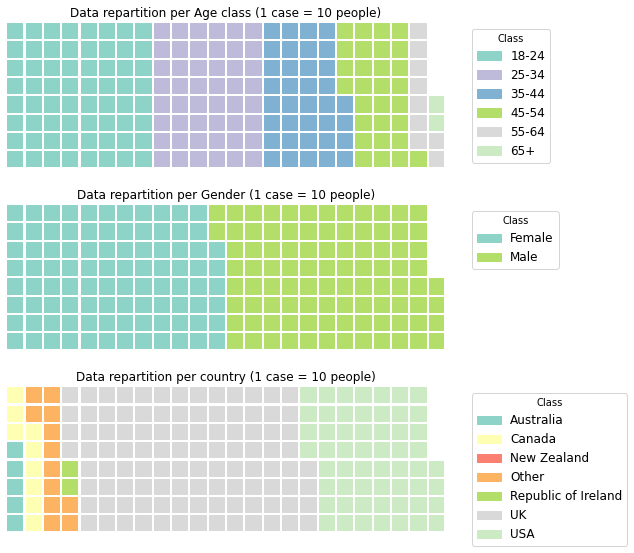

In [8]:
dfage=df.groupby('age').size().reset_index(name='counts')
dfsex=df.groupby('gender').size().reset_index(name='counts')
dfcountry=df.groupby('country').size().reset_index(name='counts')


dfage["counts"]=dfage["counts"]/10
dfsex["counts"]=dfsex["counts"]/10
dfcountry["counts"]=dfcountry["counts"]/10


cate = dfage.shape[0]
cate2= dfsex.shape[0]
cate3= dfcountry.shape[0]


colors = [plt.cm.Set3(i/float(cate)) for i in range(cate)]
colors2 = [plt.cm.Set3(i/float(cate2)) for i in range(cate2)]
colors3 = [plt.cm.Set3(i/float(cate3)) for i in range(cate3)]


fig = plt.figure(
    FigureClass=Waffle,
    rows=8,
    figsize=(10, 8),
    plots={
        '311': {
            'values': dfage['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfage[['age', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per Age class (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors
        },
        '312': {
            'values': dfsex['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfsex[['gender', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per Gender (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors2
        },
        '313': {
            'values': dfcountry['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfcountry[['country', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per country (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors3
        },
    },
)     

In [9]:
df.groupby("age").agg({"nscore":(np.average,np.std),"escore":(np.average,np.std),"oscore":(np.average,np.std),"ascore":(np.average,np.std),"cscore":(np.average,np.std)})

nscore               escore               oscore            \
         average       std    average       std    average       std   
age                                                                    
18-24  37.041991  9.421248  39.662519  7.249854  47.825816  6.241317   
25-34  36.515593  9.216169  39.943867  7.064212  45.490644  6.869347   
35-44  35.822535  8.909434  39.002817  6.341282  44.008451  6.429754   
45-54  33.965986  8.271762  39.765306  6.066977  44.268707  5.872877   
55-64  32.419355  8.283460  39.258065  5.725426  44.623656  6.490652   
65+    31.833333  9.319493  36.722222  4.169999  40.833333  8.576644   

          ascore               cscore            
         average       std    average       std  
age                                              
18-24  42.264386  6.517536  39.494557  7.413754  
25-34  43.029106  6.842513  41.962578  6.685078  
35-44  42.777465  5.994211  42.425352  6.600114  
45-54  44.149660  6.026510  43.057823  6.133892  
55-64  42.655914  6.013562  42.440860  6.323631  
65+    42.222222  7.191135  45.611111  5.370276

In [10]:
df.groupby("gender").agg({"nscore":np.average,"escore":np.average,"oscore":np.average,"ascore":np.average,"cscore":np.average})

,nscore,escore,oscore,ascore,cscore
gender,,,,,
Female,36.562168,39.994687,44.829968,44.293305,42.719447
Male,35.278897,39.162248,46.628844,41.448568,40.156946


In [11]:
dfAD=df.groupby(["age","ecstasy"]).size().unstack(fill_value=0).stack().reset_index(name='counts')
dfAD=dfAD.set_index(["age","ecstasy"])
dfAD.head(10)


counts
age   ecstasy                       
18-24 Never Used                 247
      Used in Last Day            16
      Used in Last Decade         70
      Used in Last Month         101
      Used in Last Week           36
      Used in Last Year          172
      Used over a Decade Ago       1
25-34 Never Used                 240
      Used in Last Day             2
      Used in Last Decade         85

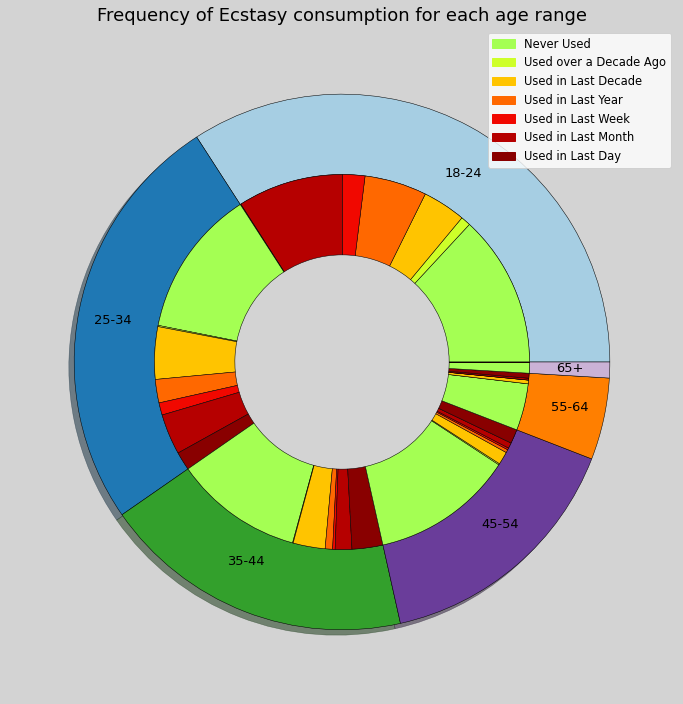

In [12]:
color = plt.cm.jet
color2= plt.cm.Paired

outer_colors = [color2(0),color2(0.15),color2(0.30),color2(0.8),color2(0.6),color2(0.7)]
inner_colors = [color(.55), color(.6), color(.7), color(.8), color(.9), color(.95), color(0.99)]*7
                
    
label1 = list(['18-24','25-34','35-44','45-54','55-64','65+'])
label2=list(['Never Used','Used in Last Day','Used in Last Decade','Used in Last Month','Used in Last Week','Used in Last Year','Used over a Decade Ago'])*6
size = 0.3
vals = dfAD['counts']
group_sum = dfAD.groupby('age')['counts'].sum()


fig, ax = plt.subplots(figsize=(12,16), facecolor="lightgrey")
        
ax.pie(group_sum, 
       radius=1,
       labels=label1,
       colors=outer_colors,
       labeldistance=0.8,
       textprops={'fontsize': 13},
       shadow = True,
       wedgeprops=dict(width=size, edgecolor='black',linewidth=0.5))

ax.pie(vals, 
       radius=1-size,
       colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='black',linewidth=0.5))

ax.set_title('Frequency of Ecstasy consumption for each age range',fontsize=18)


a = mpatches.Patch(color=inner_colors[0], label='Never Used')
b = mpatches.Patch(color=inner_colors[1], label='Used over a Decade Ago')
c = mpatches.Patch(color=inner_colors[2], label='Used in Last Decade')
d = mpatches.Patch(color=inner_colors[3], label='Used in Last Year')
e = mpatches.Patch(color=inner_colors[4], label='Used in Last Week')
f = mpatches.Patch(color=inner_colors[5], label='Used in Last Month')
g = mpatches.Patch(color=inner_colors[6], label='Used in Last Day')
plt.legend(handles=[a,b,c,d,e,f,g],prop={'size': 11.5})


In [13]:
world=geo.read_file(geo.datasets.get_path('naturalearth_lowres'))

dfw=df[["country","alcohol"]]
dfw["alcohol"]=dfw["alcohol"].apply(lambda x: 1 if x in ("Used in Last Week","Used in Last Day","Used in Last Month") else 0)
dfw=dfw.groupby(["country"]).agg({"alcohol":["sum","count"]})
dfw['prop']=round(dfw['alcohol','sum']/dfw['alcohol','count']*100,2)
dfw.reset_index(inplace=True)

dfw["country"]=dfw["country"].apply(lambda x: 'Ireland' if x=='Republic of Ireland' else x)
dfw["country"]=dfw["country"].apply(lambda x: 'United Kingdom' if x=='UK' else x)
dfw["country"]=dfw["country"].apply(lambda x: 'United States of America' if x=='USA' else x)

dfw=world.merge(dfw,how='left',left_on=['name'],right_on=['country'])
dfw.dropna(inplace=True)
dfw.columns = ['pop', 'continent', 'name', 'iso_a3', 'gdp_md_est','geometry','country','sum','count','prop']



mapdrug = folium.Map()

# Add the data
folium.Choropleth(
    geo_data=dfw,
    name='choropleth',
    data=dfw,
    columns=['country', 'prop'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of People who have drink alchool during the last Month per Country'
).add_to(mapdrug)

mapdrug


C:\Users\bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\bruno\Anaconda3\lib\site-packages\pandas\core\frame.py:9204: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  validate=validate,


In [14]:
nbUK=df.groupby("country").size()["UK"]
nbUSA=df.groupby("country").size()["USA"]

dfUSA=df[df["country"]=="USA"]
dfUK=df[df["country"]=="UK"]

drug_list=["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
          "lsd","meth","mushrooms","nicotine","semer","vsa"]

for i in drug_list:
    dfUK[i].replace(User, inplace=True)
    dfUSA[i].replace(User, inplace=True)

dfUSA = dfUSA.drop(dfUSA.columns[0:12], 1)
dfUK = dfUK.drop(dfUK.columns[0:12], 1)

labels=dfUSA.columns

valuesUSA=[]
valuesUK=[]

for i in labels :
    try :
        valuesUSA.append(dfUSA[i].value_counts()["User"])
    except :
        valuesUSA.append(0)
        
    try : 
        valuesUK.append(dfUK[i].value_counts()["User"])
    except :
        valuesUK.append(0)

#Conversion pourcentages : 
def convPourcentage (liste,nb):
    for i in range(len(liste)):
        liste[i]=round(liste[i]*100/nb,1)
    return liste

valuesUSA=convPourcentage(valuesUSA,nbUSA)
valuesUK=convPourcentage(valuesUK,nbUK)

C:\Users\bruno\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


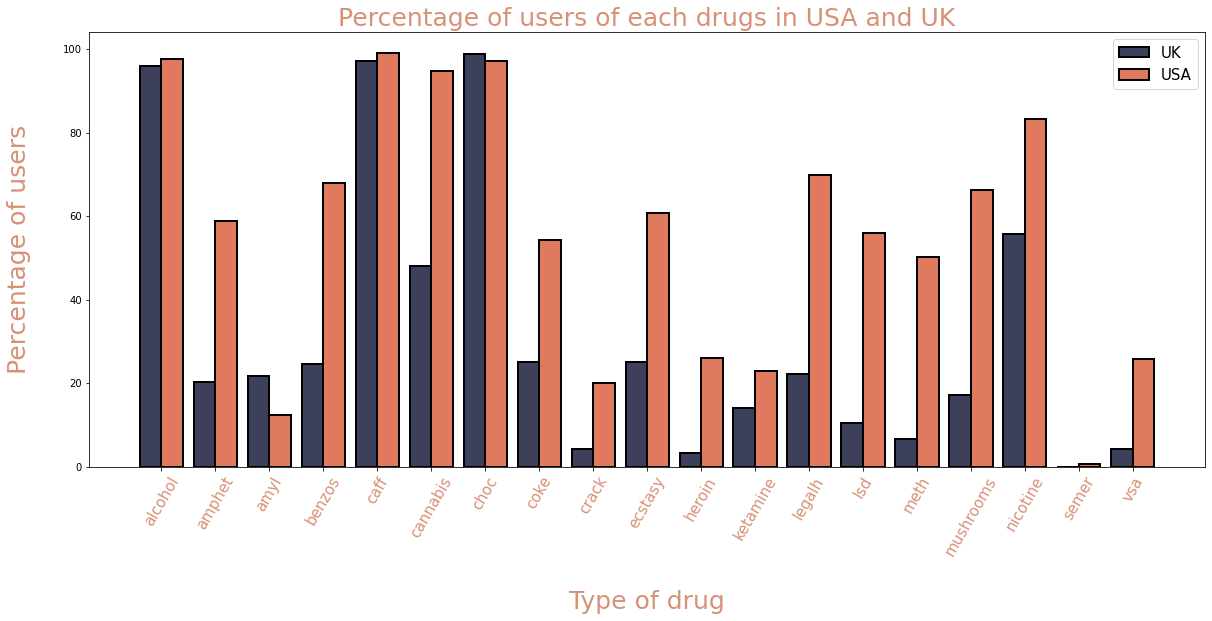

In [15]:
largeur_barre = 0.4 # Largeur de chaque barre : 

# attention si valeur trop grande, il n'y aura pas de différence entre chaque paquet de barres
plt.figure(figsize=(20,8))

x1 = range(len(valuesUK)) # Position des barres de la catégorie 1

x2 = [i + largeur_barre for i in x1] # Position des barres de la cat 2


plt.bar(x1, valuesUK, width = largeur_barre, color = '#3d405b', # Barres cat 1

           edgecolor = 'black', linewidth = 2)

plt.bar(x2, valuesUSA, width = largeur_barre, color = '#e07a5f', # Barres cat 2

           edgecolor = ['black' for i in valuesUK], linewidth = 2)

plt.xticks([r + largeur_barre / 2 for r in range(len(valuesUK))], # Etiquettes

              labels)
plt.xlabel('\nType of drug', fontsize=25, color='#D79176')
plt.xticks(rotation= 60, fontsize=15,color='#D79176')
plt.ylabel("Percentage of users\n", fontsize=25, color='#D79176')
plt.title("Percentage of users of each drugs in USA and UK",fontsize=25, color='#D79176')
plt.legend(["UK","USA"],loc='upper right',fontsize=15)

In [16]:
dfscp=df.copy()
dfscp.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)

drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']

for i in drugList:
    dfscp[i]=dfscp[i].map(User)

condition = ((dfscp['amphet'] != 'User') & 
             (dfscp['amyl'] != 'User') &
             (dfscp['benzos'] != 'User') &
             (dfscp['cannabis'] != 'User') &
             (dfscp['coke'] != 'User') &
             (dfscp['crack'] != 'User') &
             (dfscp['ecstasy'] != 'User') &
             (dfscp['heroin'] != 'User') &
             (dfscp['ketamine'] != 'User') &
             (dfscp['lsd'] != 'User') &
             (dfscp['meth'] != 'User') &
             (dfscp['vsa'] != 'User'))


dfscp.loc[condition, 'Drug'] = 0
dfscp.loc[~condition, 'Drug'] = 1

for i in drugList:
    dfscp.drop(columns=[i],inplace=True)

dfscp=dfscp[['Drug','nscore','oscore','cscore','ascore','escore']]

dfscp1=dfscp.loc[dfscp['Drug'] == 1.0]
dfscp0=dfscp.loc[dfscp['Drug'] == 0.0]

dfscp1=dfscp1.drop(columns=['Drug'])
dfscp0=dfscp0.drop(columns=['Drug'])


prov1 = np.concatenate([([i]*1412) for i in ['Neuroticism','Openness to experience','Conscientiousness','Agreeableness','Extraversion']], axis=0)
prov0 = np.concatenate([([i]*472) for i in ['Neuroticism','Openness to experience','Conscientiousness','Agreeableness','Extraversion']], axis=0)


dfscp1=pd.DataFrame(dfscp1.values.ravel('F'))
dfscp1['g']=prov1
dfscp1=dfscp1.rename(columns={0: "x"})


dfscp0=pd.DataFrame(dfscp0.values.ravel('F'))
dfscp0['g']=prov0
dfscp0=dfscp0.rename(columns={0: "x"})


C:\Users\bruno\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\bruno\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


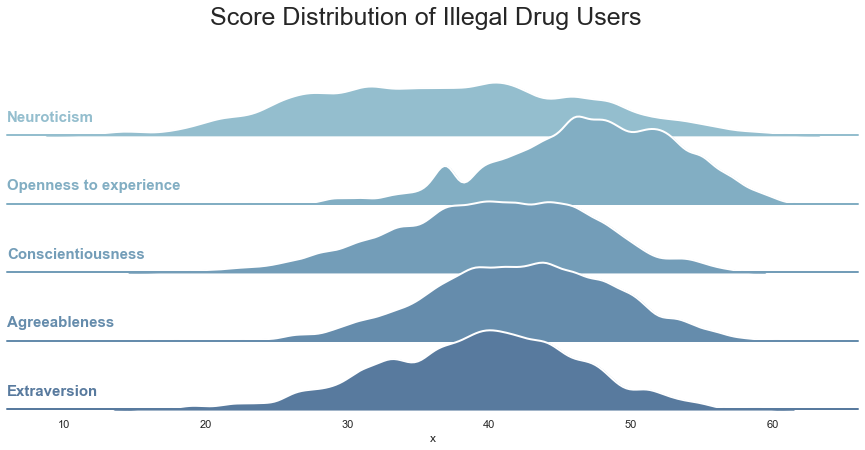

C:\Users\bruno\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\bruno\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


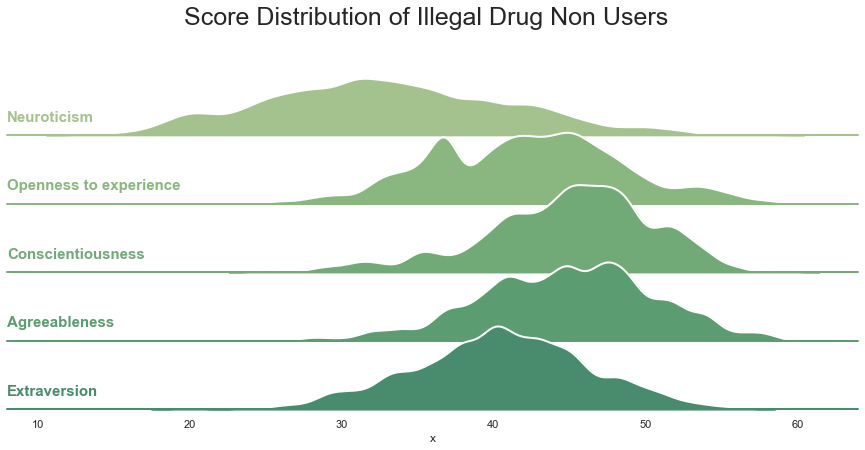

In [17]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(10, rot=-0.2, light=.7)
g = sns.FacetGrid(dfscp1, row="g", hue="g", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=15)


g.map(label, "x")

g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Score Distribution of Illegal Drug Users',fontsize=25)

plt.gcf().set_size_inches(13, 7)

plt.show()

########################################

pal = sns.cubehelix_palette(10, rot=-0.6, light=.7)
g = sns.FacetGrid(dfscp0, row="g", hue="g", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(label, "x")

g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Score Distribution of Illegal Drug Non Users',fontsize=25)

plt.gcf().set_size_inches(13, 7)




## 3. Machine Learning <a class="anchor" id="chapter3"></a>



### a/ Dataset <a class="anchor" id="section_3_1"></a>

In [18]:
print(df["ecstasy"].unique())

['Used in Last Month' 'Never Used' 'Used over a Decade Ago'
 'Used in Last Year' 'Used in Last Decade' 'Used in Last Day'
 'Used in Last Week']


In [19]:
dfml=df.copy()
dfml.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)
dfml["semer"]=dfml["semer"].apply(lambda x: 1 if x in ('Used in Last Month', 'Used over a Decade Ago','Used in Last Year', 'Used in Last Decade', 'Used in Last Day','Used in Last Week') else 0)
dfml.drop(dfml[dfml['semer']==1].index, inplace=True)
#8 liers have been removed
dfml.drop(columns=['semer'],inplace=True)
drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']
for i in drugList:
    dfml[i]=dfml[i].map(User)




condition = ((dfml['amphet'] != 'User') & 
             (dfml['amyl'] != 'User') &
             (dfml['benzos'] != 'User') &
             (dfml['cannabis'] != 'User') &
             (dfml['coke'] != 'User') &
             (dfml['crack'] != 'User') &
             (dfml['ecstasy'] != 'User') &
             (dfml['heroin'] != 'User') &
             (dfml['ketamine'] != 'User') &
             (dfml['lsd'] != 'User') &
             (dfml['meth'] != 'User') &
             (dfml['vsa'] != 'User'))


dfml.loc[condition, 'Drug'] = 0
dfml.loc[~condition, 'Drug'] = 1

for i in drugList:
    dfml.drop(columns=[i],inplace=True)

dfml.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug
id,,,,,,,,,,,,,
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,1.0
3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,1.0
4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,1.0
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,1.0
6,65+,Female,Left school at 18 years,Canada,White,29,38,35,55,52,-1.37983,-1.54858,0.0


In [20]:
#Then we replace other cateorical variables by continuous value.

dfml["age"]=dfml["age"].apply(lambda x: random.randrange(25, 34) if x=='25-34' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(18, 24) if x=='18-24' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(35, 44) if x=='35-44' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(45, 54) if x=='45-54' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(55, 64) if x=='55-64' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(65, 100) if x=='65+' else x)

edu_dict = {
    "Left school before 16 years": 0,
    "Left school at 16 years":1,
    'Left school at 17 years':2,
    "Left school at 18 years":3,
    "Some college or university, no certificate or degree":4,
    "Professional certificate/ diploma":5,
    "University degree":6,
    "Masters degree":7,
    "Doctorate degree":8
    }

dfml["gender"] = dfml["gender"].astype('category')
dfml["gender"] = dfml["gender"].cat.codes

dfml["country"] = dfml["country"].astype('category')
dfml["country"] = dfml["country"].cat.codes

dfml['Drug']=pd.to_numeric(dfml['Drug'],downcast='integer').astype('category')
dfml["education"].replace(edu_dict, inplace=True)
dfml.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug
id,,,,,,,,,,,,,
2,31,1,8,5,White,29,52,55,48,41,-0.71126,-0.21575,1
3,39,1,5,5,White,31,45,40,32,34,-1.37983,0.40148,1
4,18,0,7,5,White,34,34,46,47,46,-1.37983,-1.18084,1
5,36,0,8,5,White,43,28,43,41,50,-0.21712,-0.21575,1
6,85,0,3,1,White,29,38,35,55,52,-1.37983,-1.54858,0


### Variance Treshold <a class="anchor" id="section_3_1_1"></a>

In [21]:
X=dfml.drop('Drug', axis=1)
X.var(axis=0)

C:\Users\bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


age          169.507990
gender         0.250132
education      3.114110
country        1.985415
nscore        83.535303
escore        45.879895
oscore        43.837940
ascore        41.399440
cscore        48.568173
impulsive      0.910857
ss             0.925346
dtype: float64

### Get Dummies & Scaled Data <a class="anchor" id="section_3_1_2"></a>

In [22]:
dfml=pd.get_dummies(dfml,columns=['gender', 'country',"ethnicity"])


#Finally we scaled the data
dfml = pd.DataFrame(MinMaxScaler().fit_transform(dfml), columns=dfml.columns)
dfml.head()

,age,education,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug,...,country_4,country_5,country_6,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
0,0.160494,1.000,0.354167,0.837209,0.861111,0.750000,0.571429,0.337920,0.465658,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.259259,0.625,0.395833,0.674419,0.444444,0.416667,0.404762,0.215401,0.619957,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.875,0.458333,0.418605,0.611111,0.729167,0.690476,0.215401,0.224398,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.222222,1.000,0.645833,0.279070,0.527778,0.604167,0.785714,0.428474,0.465658,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.827160,0.375,0.354167,0.511628,0.305556,0.895833,0.833333,0.215401,0.132468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Removing Correlated Features <a class="anchor" id="section_3_1_3"></a>

In [23]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = dfml.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,education,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug,gender_0,gender_1,country_0,country_1,country_2,country_3,country_4,country_5,country_6,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
age,1.000000,0.077549,-0.142000,-0.031607,-0.208970,0.067164,0.181970,-0.176084,-0.314953,-0.356841,0.086957,-0.086957,-0.036939,0.035089,-0.032084,-0.092817,-0.015379,0.303509,-0.277407,-0.013200,0.020067,-0.033038,-0.038647,-0.033739,-0.055407,0.061937
education,0.077549,1.000000,-0.092712,0.117888,0.080950,0.081205,0.223855,-0.113934,-0.108718,-0.161029,0.189440,-0.189440,-0.028989,-0.065491,-0.023301,-0.025430,-0.037964,0.200071,-0.152815,0.082000,0.039437,-0.007453,0.009328,0.015363,-0.001187,-0.059083
nscore,-0.142000,-0.092712,1.000000,-0.433354,0.014574,-0.215791,-0.400253,0.176288,0.083204,0.184081,0.068469,-0.068469,-0.010526,0.024225,0.019712,-0.016835,-0.010404,-0.133634,0.147477,0.009720,-0.041369,0.028109,0.035891,0.007924,-0.001886,-0.003032
escore,-0.031607,0.117888,-0.433354,1.000000,0.234266,0.159563,0.318260,0.107487,0.202581,-0.079964,0.062208,-0.062208,0.012257,-0.040520,-0.034858,-0.028467,0.033478,0.116694,-0.101438,0.017744,0.006778,0.014385,0.025350,0.011198,0.019772,-0.038181
oscore,-0.208970,0.080950,0.014574,0.234266,1.000000,0.030415,-0.061710,0.271292,0.416727,0.309066,-0.138524,0.138524,0.029894,-0.021063,0.011616,0.107769,0.003722,-0.320808,0.289316,-0.025154,-0.060964,0.015845,0.021280,-0.014912,0.065686,-0.007549
ascore,0.067164,0.081205,-0.215791,0.159563,0.030415,1.000000,0.247841,-0.232311,-0.213486,-0.179635,0.220468,-0.220468,0.003989,-0.064803,0.007496,-0.076913,0.006176,0.164855,-0.112598,-0.003383,0.018520,-0.042726,0.000432,0.012846,-0.017045,0.004920
cscore,0.181970,0.223855,-0.400253,0.318260,-0.061710,0.247841,1.000000,-0.343798,-0.234337,-0.287601,0.182376,-0.182376,-0.028743,0.006572,-0.006203,-0.090585,-0.024376,0.215149,-0.172894,0.008073,0.039349,-0.036970,-0.000982,0.012772,0.023524,-0.035727
impulsive,-0.176084,-0.113934,0.176288,0.107487,0.271292,-0.232311,-0.343798,1.000000,0.622604,0.289475,-0.169441,0.169441,0.041024,0.009725,-0.001755,0.028156,-0.023277,-0.218854,0.209908,-0.007796,-0.041662,0.048227,0.028753,0.014610,0.052322,-0.033029
ss,-0.314953,-0.108718,0.083204,0.202581,0.416727,-0.213486,-0.234337,0.622604,1.000000,0.367272,-0.245946,0.245946,0.066893,0.010490,0.017979,0.075702,0.024827,-0.334057,0.287479,-0.028594,-0.067073,0.031267,0.014177,0.000781,0.081559,-0.018675
Drug,-0.356841,-0.161029,0.184081,-0.079964,0.309066,-0.179635,-0.287601,0.289475,0.367272,1.000000,-0.222352,0.222352,0.067967,0.046083,0.029973,0.094560,0.024305,-0.409380,0.341535,-0.071883,-0.118650,0.023205,0.034111,0.009574,0.045347,0.037245


In [24]:
#From the previous matrix, we understand that we have to drop one of the gender column because obviously they are correlated 
#due to the fact that there are only 2 differents categories ( male of female)

dfml=dfml.drop('gender_0', axis=1)

### b. Supervised learning Model  <a class="anchor" id="section_3_2"></a>


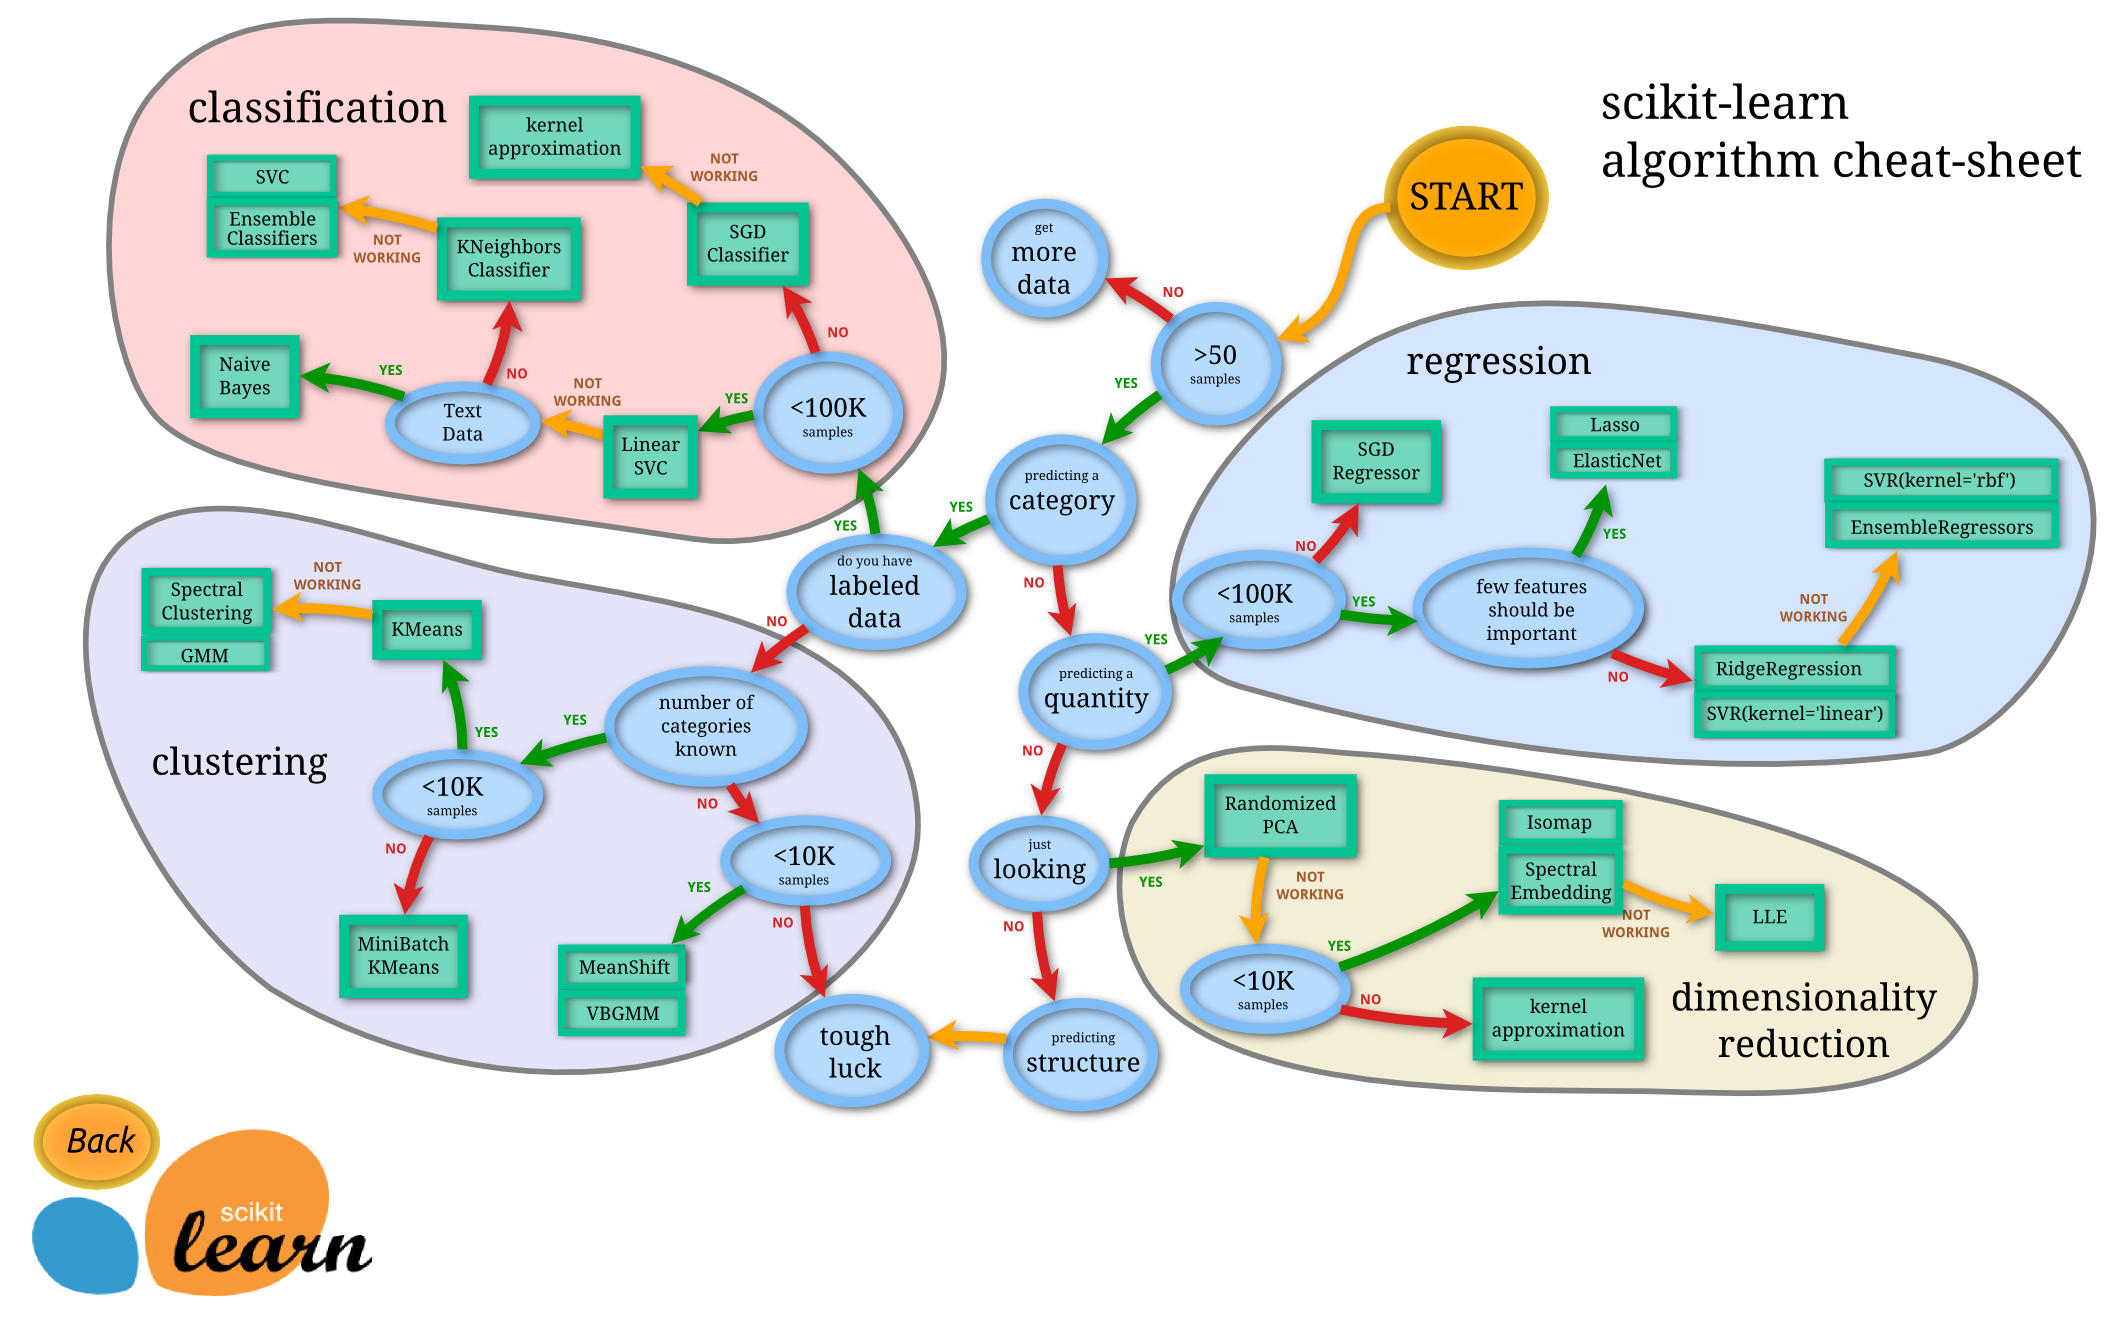

In [25]:
Image("https://scikit-learn.org/stable/_static/ml_map.png")

In [26]:
print(len(dfml))

1876


### Linear SVC <a class="anchor" id="section_3_2_1"></a>

#### 1. Normal <a class="anchor" id="section_3_2_1_1"></a>

In [27]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model= LinearSVC()
LinearSVC_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic LinearSVC :", LinearSVC_normal_score)

Accuracy basic LinearSVC : 0.8213333333333332


#### 2. Optimization - Recursive Feature Elimination and Grid Search <a class="anchor" id="section_3_2_1_2"></a>

Optimal number of features:  12


C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


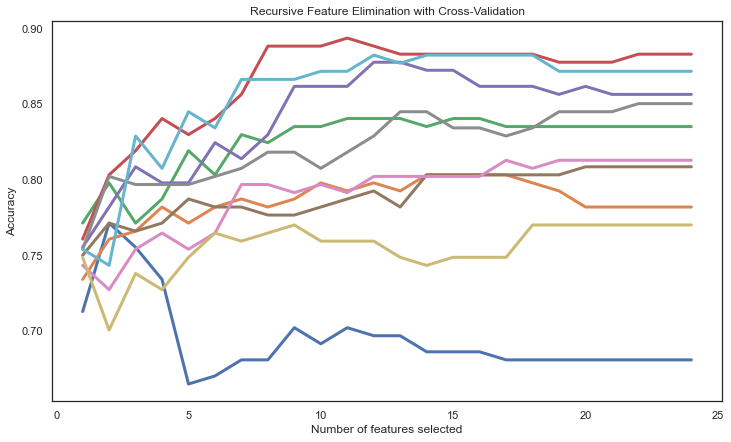

In [28]:
# It could be interesting to drop useless features to try to optimize the performance of our model.
# To do that, we will use the RFECV method

rfecv=RFECV(estimator=model,step=1,cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X, y)
print('Optimal number of features: ',rfecv.n_features_)


plt.figure(figsize=(12, 7))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

In [29]:
column = dict(zip(X.columns,rfecv.support_))
#This the list of features we will drop

filtered = [k for k,v in column.items() if v == False]
filtered

['nscore',
 'gender_1',
 'country_0',
 'country_1',
 'country_2',
 'country_3',
 'country_4',
 'country_6',
 'ethnicity_Asian',
 'ethnicity_Black',
 'ethnicity_Mixed-Black/Asian',
 'ethnicity_Other']

In [30]:
filtered.append('Drug')
X=dfml.drop(filtered, axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



tuned_parameters = {'C':np.arange(0,10,0.1)}

grid=GridSearchCV(LinearSVC(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
grid.best_score_
grid.best_params_

model=grid.best_estimator_

LinearSVC_opti_score=model.score(X_test, y_test)
print("Accuracy modified LinearSVC:", model.score(X_test, y_test))
print("The accuracy doesn't improved due to the fact that Liblinear always failed to converge during the GridSearch")






C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to conve

Accuracy modified LinearSVC: 0.8085106382978723
The accuracy doesn't improved due to the fact that Liblinear always failed to converge during the GridSearch


C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File 

### KNeighborsClassifier <a class="anchor" id="section_3_2_2"></a>

#### 1. Normal <a class="anchor" id="section_3_2_2_1"></a>

In [31]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= KNeighborsClassifier()
KNN_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic KNN :", KNN_normal_score)

Accuracy basic KNN : 0.7939999999999999


#### 2. Optimization - Grid Search <a class="anchor" id="section_3_2_2_2"></a>

In [32]:
tuned_parameters={'n_neighbors':np.arange(30,50,5),'leaf_size' : np.arange(1,10,2),'p':[1,2]}

grid=GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
KNN_opti_score=model.score(X_test, y_test)
print("Accuracy modified KNN:", model.score(X_test, y_test))

{'leaf_size': 1, 'n_neighbors': 30, 'p': 2}
Accuracy modified KNN: 0.8138297872340425


### SVC <a class="anchor" id="section_3_2_3"></a>

#### 1. Normal <a class="anchor" id="section_3_2_3_1"></a>

In [33]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= KNeighborsClassifier()
SVC_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic SVC :", KNN_normal_score)

Accuracy basic SVC : 0.7939999999999999


#### 2. Optimization - Recursive Feature Elimination and Grid Search <a class="anchor" id="section_3_2_3_2"></a>

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Optimal number of features : 19


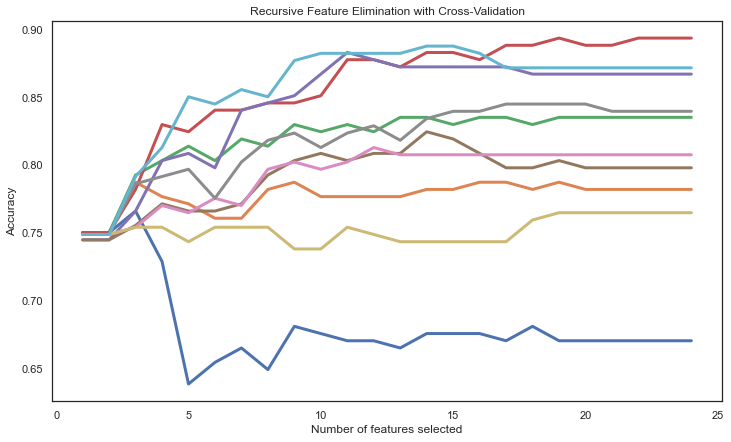

In [34]:
rfecv = RFECV(
    estimator=SVC(kernel='linear'),
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(12, 7))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
plt.show()

In [35]:
column = dict(zip(X.columns,rfecv.support_))
#This the list of features we will drop

filtered = [k for k,v in column.items() if v == False]
filtered

['country_1',
 'country_2',
 'country_4',
 'ethnicity_Mixed-Black/Asian',
 'ethnicity_Other']

In [36]:
filtered.append('Drug')
X=dfml.drop(filtered, axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



tuned_parameters={'kernel' : ['poly'],
                 'gamma' : [0.8,0.9,0.7],
                 'C': [1,2,3,4],
                 'degree' : [0,1,2]}

grid=GridSearchCV(SVC(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
SVC_opti_score=model.score(X_test, y_test)
print("Accuracy modified SVC:", model.score(X_test, y_test))

{'C': 1, 'degree': 2, 'gamma': 0.7, 'kernel': 'poly'}
Accuracy modified SVC: 0.8111702127659575


### Random Forest <a class="anchor" id="section_3_2_4"></a>

#### 1. Normal <a class="anchor" id="section_3_2_4_1"></a>

In [57]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= RandomForestClassifier()
RF_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic Random Forest :", RF_normal_score)

Accuracy basic Random Forest : 0.8153333333333332


#### 2.Optimization - Feature Elimination and Grid Search <a class="anchor" id="section_3_2_4_2"></a>

No handles with labels found to put in legend.


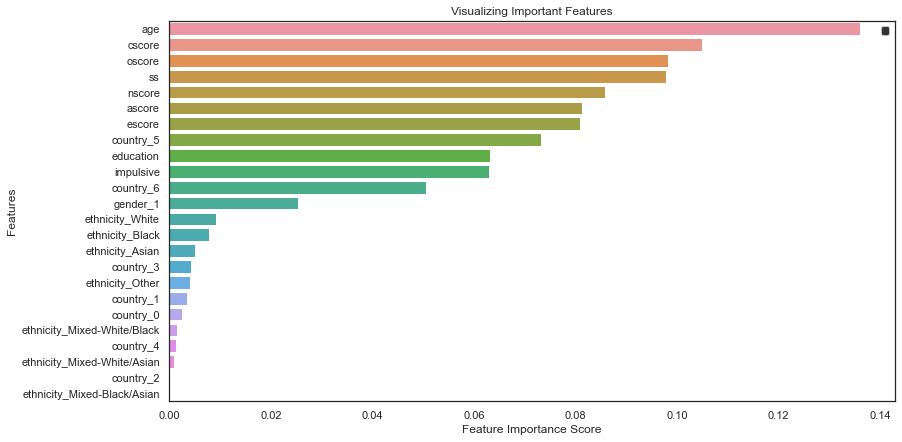

In [55]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.gcf().set_size_inches(13, 7)
plt.show()

In [62]:
X=dfml[['age','oscore','cscore','ss','nscore','country_5','ascore','escore','impulsive','education','country_6','gender_1']]
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_estimators = [5,10,15]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

param = dict(n_estimators = n_estimators, max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(RandomForestClassifier(), param, cv = 3, verbose = 1, n_jobs = -1)

grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
RF_opti_score=model.score(X_test, y_test)

print("Accuracy modified Random Forest:", model.score(X_test, y_test))

Fitting 3 folds for each of 300 candidates, totalling 900 fits
{'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 10}
Accuracy modified Random Forest: 0.824468085106383


### c. Deep Learning <a class="anchor" id="section_3_3"></a>

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
x=len(X_train.columns)
model = tf.keras.models.Sequential([


    tf.keras.layers.Dense(x,activation='relu',input_shape=(x,)),
    tf.keras.layers.Dense(100,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(80,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(200,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(50,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(80,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(200,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(50,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(20,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),    
    tf.keras.layers.Dense(1,activation='sigmoid'),
])


model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=["accuracy"])




In [39]:
history = model.fit(X_train, y_train, epochs=100,batch_size=5)

Epoch 1/100
300/300 [==============================] - 2s 4ms/step - loss: 15.3210 - accuracy: 0.7467
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 13.5875 - accuracy: 0.7520
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 12.1011 - accuracy: 0.7887
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 10.7628 - accuracy: 0.8093
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 9.5983 - accuracy: 0.8020
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 8.5581 - accuracy: 0.8013
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 7.6379 - accuracy: 0.8080
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 6.8241 - accuracy: 0.8153
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 6.0994 - accuracy: 0.8187
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 5.4629 - ac

In [40]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                380       
                                                                 
 dense_1 (Dense)             (None, 100)               2000      
                                                                 
 dense_2 (Dense)             (None, 80)                8080      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 200)               16200     
                                                                 
 dense_4 (Dense)             (None, 50)                10050     
                                                                 
 dense_5 (Dense)             (None, 80)                4

Text(0.5, 1.0, 'Training and validation loss')

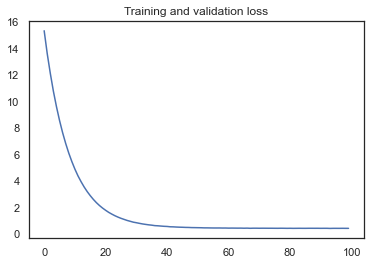

In [41]:
loss= history.history['loss']
epochs= np.arange(100)
plt.plot  ( epochs,loss )
plt.title ('Training and validation loss')

In [42]:
test_loss, DL_score = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', DL_score)

12/12 - 0s - loss: 0.4753 - accuracy: 0.8059 - 288ms/epoch - 24ms/step

Test accuracy: 0.8058510422706604


### Machine Learning Model Comparison

Text(0.5, 0, 'Accuracy')

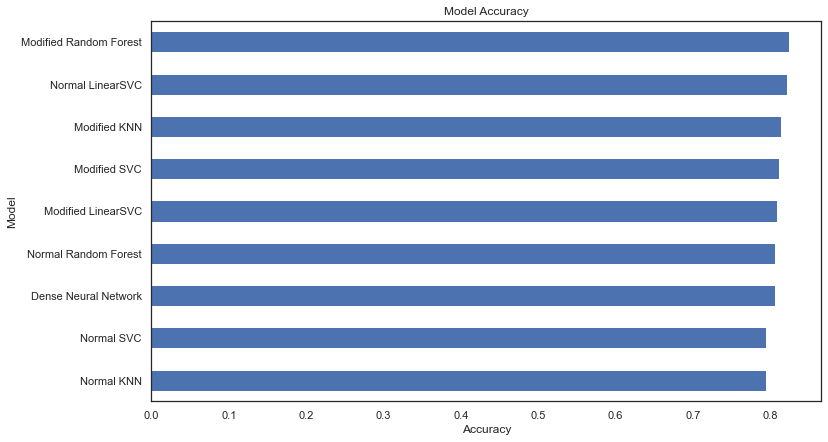

In [63]:
model_label=['Normal Random Forest','Modified Random Forest','Normal LinearSVC','Modified LinearSVC','Normal KNN','Modified KNN','Normal SVC','Modified SVC','Dense Neural Network']
model_score=[RF_normal_score,RF_opti_score,LinearSVC_normal_score,LinearSVC_opti_score,KNN_normal_score,KNN_opti_score,SVC_normal_score,SVC_opti_score,DL_score]

dfacc = pd.DataFrame()
dfacc['Model']  = model_label
dfacc['Accuracy']  = model_score
dfacc = dfacc.sort_values(by='Accuracy')
dfacc=dfacc.set_index('Model')


dfacc['Accuracy'].plot(kind="barh",figsize=(12, 7))
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
